### 1. Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import sklearn as sk

import sklearn.metrics as metrics
import os
import pickle
import itertools  

from matplotlib import rc
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
import plotly.express as px
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
#import statsmodels.api as sm
from statsmodels.formula.api import ols
import random

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [4]:
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

In [5]:
from sklearn.metrics import matthews_corrcoef

In [6]:
# Set the global font to be DejaVu Sans, size 10 
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 2. Load pickles

In [7]:
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_bcorr.pkl', 'rb') as handle:
    prec_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prot_bcorr.pkl', 'rb') as handle:
    prot_bcorr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/prec_2_gr.pkl', 'rb') as handle:
    prec_2_gr = pickle.load(handle)
with open(r'/Users/momenzadeha/Documents/aneurysm_study/meta_prot.pkl', 'rb') as handle:
    meta_prot = pickle.load(handle)

### 3. Find top 30 PI scores

In [8]:
# disease groups 0,1,4 => 0
# control group 2,3 => 1

In [9]:
meta_prot.Group.value_counts()

0    75
1    62
2    28
3    24
4    13
Name: Group, dtype: int64

In [10]:
#drop groups 2,3,4
values = [2,3,4]

meta_prot1 = meta_prot[meta_prot.Group.isin(values) == False]

In [11]:
meta_prot1.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [12]:
prot_all=prot_bcorr.merge(meta_prot1.Group, left_index=True, right_index=True)

In [13]:
prot1=prot_all.iloc[:,:-1]

In [14]:
prot1.shape

(137, 195)

In [15]:
meta_prot1.shape

(137, 239)

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(prot1,meta_prot1.Group, 
                                                    random_state=42, test_size=0.2,
                                                    stratify=meta_prot1.Group) 

In [17]:
prot1.shape

(137, 195)

In [18]:
Xtrain.shape

(109, 195)

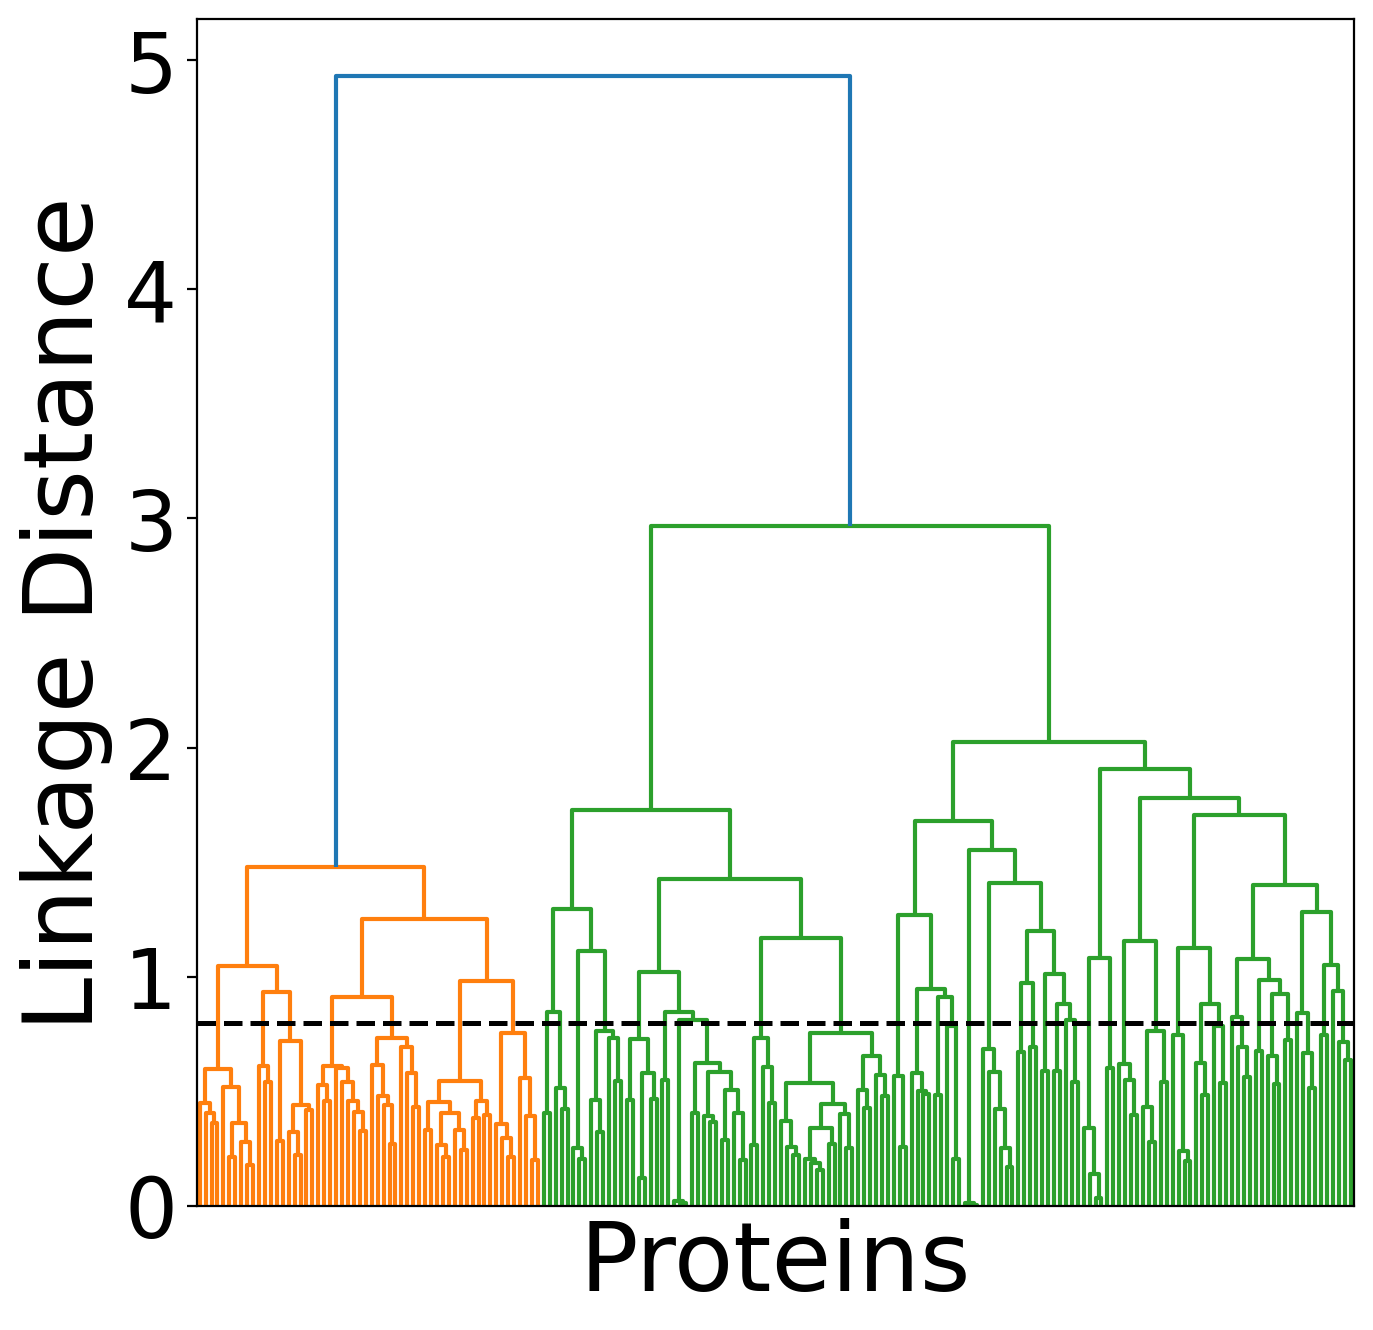

In [19]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 7))

corr = spearmanr(Xtrain).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, ax=ax1, leaf_rotation=90
)
plt.yticks(fontsize=30)
plt.xlabel('Proteins', fontsize=35)
plt.ylabel('Linkage Distance', fontsize=35)
fig.tight_layout()
plt.xticks([])

pyplot.plot([0,2000], [0.8,0.8], linestyle='--', linewidth=1.8, color='black',
            label='Selected threshold')
#plt.savefig('SFig3B_v2.svg',bbox_inches='tight')

In [20]:
corr[dendro["leaves"], :][:, dendro["leaves"]].shape

(195, 195)

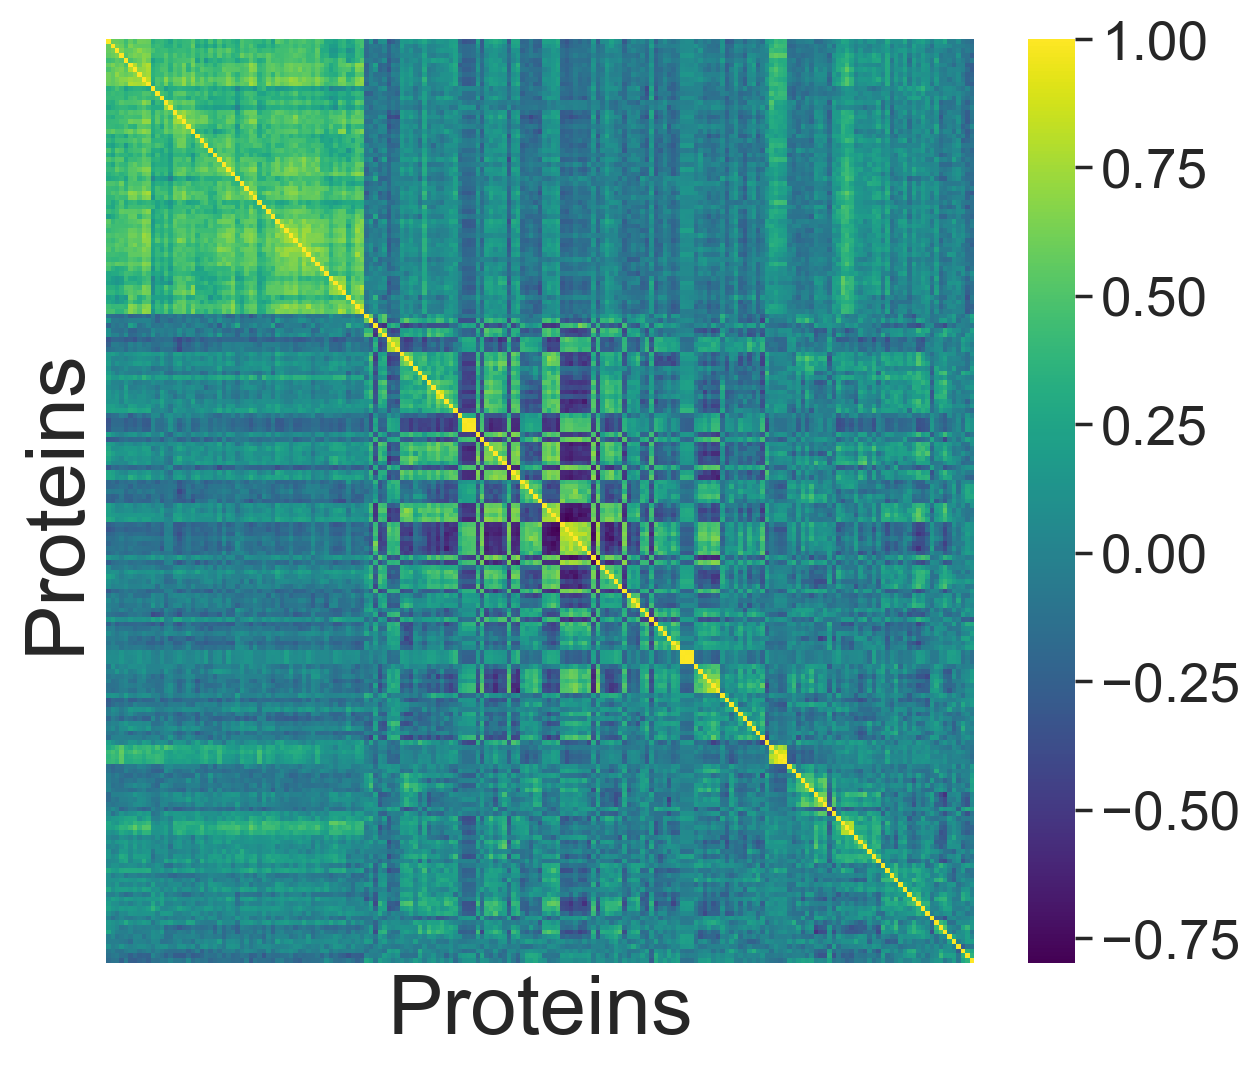

In [21]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(7,6)},font_scale=1.8)
ax=sns.heatmap(corr[dendro["leaves"], :][:, dendro["leaves"]],cmap='viridis',yticklabels=False, xticklabels=False)
pyplot.xlabel('Proteins', fontsize=30)
pyplot.ylabel('Proteins', fontsize=30)
#plt.savefig('SFig3A_v2.svg',bbox_inches='tight')
plt.show()

In [22]:
np.arange(0,5,0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [23]:
def get_sel_features(input_df, output_df, threshold):
    corr = spearmanr(input_df).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
    dist_linkage, labels=input_df.columns.tolist(), ax=ax1, leaf_rotation=90)

    #Xtrain, Xtest, ytrain, ytest = train_test_split(input_df, output_df, 
                                                    #random_state=42, test_size=0.2,
                                                    #stratify=output_df) 
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    Xtrain_sel = input_df.iloc[:, selected_features]
    return Xtrain_sel

In [24]:
for i in np.arange(0,2.2,0.2):
    print(i)
    print(len(get_sel_features(Xtrain,meta_prot1.Group,i).columns))

0.0
195
0.2
183
0.4
140
0.6000000000000001
80
0.8
46
1.0
29
1.2000000000000002
19
1.4000000000000001
13
1.6
9
1.8
5
2.0
4


In [25]:
#hyperparameter optimization on training set
    
#parameters
Dummy_params = {}

GB_params = {
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

LR_params = {
    'C':[0.01,0.1,1,10,100],
    'penalty':['l2'],
    'solver':['newton-cg'],
    'max_iter':[100,200,300]}

ET_params = {
    'bootstrap': [True, False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}

RF_params = {
    'bootstrap': [True,False],
    'max_depth': [5,50,100],
    'n_estimators':[10,100,500],
    'max_features':['sqrt','log2'],
    'min_samples_leaf': [2, 20, 80, 200, 300],
    'min_samples_split': [2, 20, 80, 200, 300]}
           
KNN_params = {
    'leaf_size': [1,5,10,15,20,25,30,35,40,45,50],
    'n_neighbors': [1,5,10,15,20,25,30],
    'p': [1,2]}
    
models_dict = {
    'Dummy': DummyClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'LR': LogisticRegression(random_state=42),
    'ET': ExtraTreesClassifier(random_state=42),
    'RF': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()}

params_dict = {
    'Dummy': Dummy_params,
    'GB':GB_params,
    'SVC':SVC_params,
    'LR':LR_params,
    'ET': ET_params,
    'RF': RF_params,
    'KNN': KNN_params}

#run randomsearch
all_model_dict = {}
all_F1_dict = {}
all_AUPR_dict = {}

for i in np.arange(0,2.2,0.2):
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    temp_3 = {}
    Xtrain_sel=get_sel_features(Xtrain,meta_prot1.Group,i)
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions = params_dict[x],
                                 scoring='f1', refit=True, cv=5, n_iter=200, random_state=0)
        clf.fit(Xtrain_sel, ytrain)
        y_predict_proba = clf.predict_proba(Xtrain_sel)[:,1]
        precision, recall, thresholds = precision_recall_curve(ytrain,y_predict_proba)
        print('Best AUPR:',auc(recall, precision))
        print('Best F1:',clf.best_score_)
        print('Best estimator:',clf.best_estimator_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
        temp_3[x] = auc(recall, precision)
    all_model_dict[i] = temp_1
    all_F1_dict[i] = temp_2
    all_AUPR_dict[i] = temp_3
    
all_F1_df=pd.DataFrame.from_dict(all_F1_dict)
all_AUPR_df=pd.DataFrame.from_dict(all_AUPR_dict)

Input: 0.0
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.6260818713450292
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='log2',
                           min_samples_leaf=20, min_samples_split=20,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5803356216628528
Best estimator: SVC(C=10, gamma=0.01, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line sear

Best AUPR: 1.0
Best F1: 0.5702373581011352
Best estimator: LogisticRegression(C=1, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.8658624654886968
Best F1: 0.5121318447634237
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=100, max_features='log2',
                     min_samples_leaf=2, min_samples_split=20, n_estimators=10,
                     random_state=42)
RF
Best AUPR: 0.99916684020547
Best F1: 0.5612922243996412
Best estimator: RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=2,
                       n_estimators=10, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.7732635159326888
Best F1: 0.5268525592055003
Best estimator: KNeighborsClassifier(leaf_size=1, p=1)
Input: 0.2
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 1.0
Best F1: 0.5789598997493735
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='log2',
                           min_samples_leaf=20, min_samples_split=20,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5437991056071552
Best estimator: SVC(C=10, gamma=0.01, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line sear

Best AUPR: 1.0
Best F1: 0.5323626373626373
Best estimator: LogisticRegression(C=10, random_state=42, solver='newton-cg')
ET
Best AUPR: 1.0
Best F1: 0.5457860337117303
Best estimator: ExtraTreesClassifier(max_depth=50, max_features='log2', min_samples_leaf=2,
                     random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.5505882352941176
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='log2',
                       min_samples_leaf=2, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 1.0
Best F1: 0.4925978046721081
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=1)
Input: 0.4
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 1.0
Best F1: 0.6252631578947367
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=100, max_features='log2',
                           min_samples_leaf=2, random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5792458521870287
Best estimator: SVC(C=0.1, gamma=1, kernel='poly', probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line sear

Best AUPR: 1.0
Best F1: 0.5640825647782168
Best estimator: LogisticRegression(C=100, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.9780350111667035
Best F1: 0.5428456050612465
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=50, max_features='sqrt',
                     min_samples_leaf=2, n_estimators=10, random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.5111936704506364
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='log2',
                       min_samples_leaf=2, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.8065723609031241
Best F1: 0.5314791668002059
Best estimator: KNeighborsClassifier(leaf_size=1)
Input: 0.6000000000000001
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 1.0
Best F1: 0.6122037714607373
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='log2',
                           min_samples_leaf=20, n_estimators=500,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5657142857142856
Best estimator: SVC(C=100, gamma=0.01, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


Best AUPR: 1.0
Best F1: 0.5223692028645589
Best estimator: LogisticRegression(C=10, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.992519556702363
Best F1: 0.524092589332864
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=50, max_features='sqrt',
                     min_samples_leaf=2, n_estimators=10, random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.5015359477124183
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=500, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.7898876649219693
Best F1: 0.49739272520602446
Best estimator: KNeighborsClassifier(leaf_size=1)
Input: 0.8
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 0.9995876718034152
Best F1: 0.6340259740259739
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='log2',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=10, random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5749707602339182
Best estimator: SVC(C=0.1, gamma=1, kernel='poly', probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


Best AUPR: 0.9716203571542488
Best F1: 0.5602339181286549
Best estimator: LogisticRegression(C=100, random_state=42, solver='newton-cg')
ET
Best AUPR: 1.0
Best F1: 0.48588235294117643
Best estimator: ExtraTreesClassifier(max_depth=50, max_features='log2', min_samples_leaf=2,
                     random_state=42)
RF
Best AUPR: 1.0
Best F1: 0.5398778809769521
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='log2',
                       min_samples_leaf=2, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.6358630596625726
Best F1: 0.5139181286549708
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=25)
Input: 1.0
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 1.0
Best F1: 0.5639589169000934
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=50, max_features='sqrt',
                           min_samples_leaf=2, random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.2696576694130899
Best F1: 0.5899248120300753
Best estimator: SVC(C=100, gamma=0.01, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.7911337641730718
Best F1: 0.5320669096984887
Best estimator: LogisticRegression(C=100, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.9873709820124135
Best F1: 0.43862745098039213
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=50, max_features='sqrt',
                     min_samples_leaf=2, n_estimators=10, random_state=42)
RF
Best AUPR: 0.9972678720228092
Best F1: 0.5712443438914026
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=20,
                       n_estimators=10, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.7095249456139249
Best F1: 0.4439490884072928
Best estimator: KNeighborsClassifier(leaf_size=1)
Input: 1.2000000000000002
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.49380952380952375
Best estimator: GradientBoostingClassifier(learning_rate=0.5, max_depth=5, max_features='sqrt',
                           min_samples_leaf=20, n_estimators=500,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.8350959109592803
Best F1: 0.518095238095238
Best estimator: SVC(C=0.1, gamma=1, kernel='poly', probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.6345136957505272
Best F1: 0.3500653594771242
Best estimator: LogisticRegression(C=1, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.9796238163846049
Best F1: 0.41123569794050346
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=50, max_features='sqrt',
                     min_samples_leaf=2, n_estimators=10, random_state=42)
RF
Best AUPR: 0.9875683365907166
Best F1: 0.4388519465757318
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=20,
                       n_estimators=10, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 1.0
Best F1: 0.45311004784688996
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
Input: 1.4000000000000001
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB


The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 1.0
Best F1: 0.5297105508870213
Best estimator: GradientBoostingClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.28301809491275
Best F1: 0.5615584415584415
Best estimator: SVC(C=0.1, gamma=1, kernel='poly', probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.5689611107898618
Best F1: 0.31649122807017543
Best estimator: LogisticRegression(C=1, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.7961708346229713
Best F1: 0.3919607843137255
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=100, max_features='log2',
                     min_samples_leaf=2, min_samples_split=20, n_estimators=10,
                     random_state=42)
RF
Best AUPR: 0.7639100924508656
Best F1: 0.6657097288676236
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=80,
                       n_estimators=10, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 1.0
Best F1: 0.5512447125719436
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=1)
Input: 1.6
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 1.0
Best F1: 0.5705314009661835
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='log2',
                           min_samples_leaf=20, min_samples_split=20,
                           random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.7493597232882435
Best F1: 0.5249423022797636
Best estimator: SVC(C=100, gamma=0.1, kernel='poly', probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.5489835607548441
Best F1: 0.35436876504987963
Best estimator: LogisticRegression(C=10, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.9166690780674018
Best F1: 0.4375136937366039
Best estimator: ExtraTreesClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                     min_samples_split=20, n_estimators=10, random_state=42)
RF
Best AUPR: 0.7842001486189973
Best F1: 0.6060028860028859
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=80,
                       n_estimators=500, random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 1.0
Best F1: 0.5889683794466404
Best estimator: KNeighborsClassifier(leaf_size=1, n_neighbors=1)
Input: 1.8
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 0.8428000637372177
Best F1: 0.633073593073593
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=100, max_features='log2',
                           min_samples_leaf=20, min_samples_split=80,
                           n_estimators=10, random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.26895577113710867
Best F1: 0.5066332497911444
Best estimator: SVC(C=100, gamma=1, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.5037902825874105
Best F1: 0.28989621489621487
Best estimator: LogisticRegression(C=100, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.8307432086932858
Best F1: 0.4762091503267973
Best estimator: ExtraTreesClassifier(bootstrap=True, max_depth=5, max_features='log2',
                     min_samples_leaf=2, n_estimators=10, random_state=42)
RF
Best AUPR: 0.8074066549939675
Best F1: 0.6143935926773455
Best estimator: RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=80,
                       random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.740133439541103
Best F1: 0.49754385964912273
Best estimator: KNeighborsClassifier(leaf_size=1, p=1)
Input: 2.0
Dummy
Best AUPR: 0.7247706422018348
Best F1: 0.0
Best estimator: DummyClassifier(random_state=42)
GB
Best AUPR: 0.8566647628886785
Best F1: 0.5816912272155239
Best estimator: GradientBoostingClassifier(learning_rate=1, max_depth=100, max_features='log2',
                           min_samples_leaf=20, min_samples_split=80,
                           n_estimators=10, random_state=42)
SVC


The total space of parameters 48 is smaller than n_iter=200. Running 48 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.26925228410838054
Best F1: 0.545221386800334
Best estimator: SVC(C=100, gamma=1, probability=True, random_state=42)
LR


The total space of parameters 15 is smaller than n_iter=200. Running 15 iterations. For exhaustive searches, use GridSearchCV.


Best AUPR: 0.5059205043635755
Best F1: 0.2785714285714286
Best estimator: LogisticRegression(C=10, random_state=42, solver='newton-cg')
ET
Best AUPR: 0.7981343539482798
Best F1: 0.5223684210526315
Best estimator: ExtraTreesClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                     min_samples_split=20, n_estimators=10, random_state=42)
RF
Best AUPR: 0.99228895440797
Best F1: 0.537781954887218
Best estimator: RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       random_state=42)
KNN


The total space of parameters 154 is smaller than n_iter=200. Running 154 iterations. For exhaustive searches, use GridSearchCV.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behav

Best AUPR: 0.7320121015816276
Best F1: 0.5004329004329005
Best estimator: KNeighborsClassifier(leaf_size=1, p=1)


Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepd

In [27]:
all_F1_df

0.0       0.2       0.4       0.6       0.8       1.0       1.2  \
Dummy  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GB     0.626082  0.578960  0.625263  0.612204  0.634026  0.563959  0.493810   
SVC    0.580336  0.543799  0.579246  0.565714  0.574971  0.589925  0.518095   
LR     0.570237  0.532363  0.564083  0.522369  0.560234  0.532067  0.350065   
ET     0.512132  0.545786  0.542846  0.524093  0.485882  0.438627  0.411236   
RF     0.561292  0.550588  0.511194  0.501536  0.539878  0.571244  0.438852   
KNN    0.526853  0.492598  0.531479  0.497393  0.513918  0.443949  0.453110   

            1.4       1.6       1.8       2.0  
Dummy  0.000000  0.000000  0.000000  0.000000  
GB     0.529711  0.570531  0.633074  0.581691  
SVC    0.561558  0.524942  0.506633  0.545221  
LR     0.316491  0.354369  0.289896  0.278571  
ET     0.391961  0.437514  0.476209  0.522368  
RF     0.665710  0.606003  0.614394  0.537782  
KNN    0.551245  0.588968  0.497544  0.500433

In [28]:
all_AUPR_df

0.0       0.2       0.4       0.6       0.8       1.0       1.2  \
Dummy  0.724771  0.724771  0.724771  0.724771  0.724771  0.724771  0.724771   
GB     1.000000  1.000000  1.000000  1.000000  0.999588  1.000000  1.000000   
SVC    1.000000  1.000000  1.000000  1.000000  1.000000  0.269658  0.835096   
LR     1.000000  1.000000  1.000000  1.000000  0.971620  0.791134  0.634514   
ET     0.865862  1.000000  0.978035  0.992520  1.000000  0.987371  0.979624   
RF     0.999167  1.000000  1.000000  1.000000  1.000000  0.997268  0.987568   
KNN    0.773264  1.000000  0.806572  0.789888  0.635863  0.709525  1.000000   

            1.4       1.6       1.8       2.0  
Dummy  0.724771  0.724771  0.724771  0.724771  
GB     1.000000  1.000000  0.842800  0.856665  
SVC    0.283018  0.749360  0.268956  0.269252  
LR     0.568961  0.548984  0.503790  0.505921  
ET     0.796171  0.916669  0.830743  0.798134  
RF     0.763910  0.784200  0.807407  0.992289  
KNN    1.000000  1.000000  0.740133  0.732012

In [29]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,7)},font_scale=1.8)

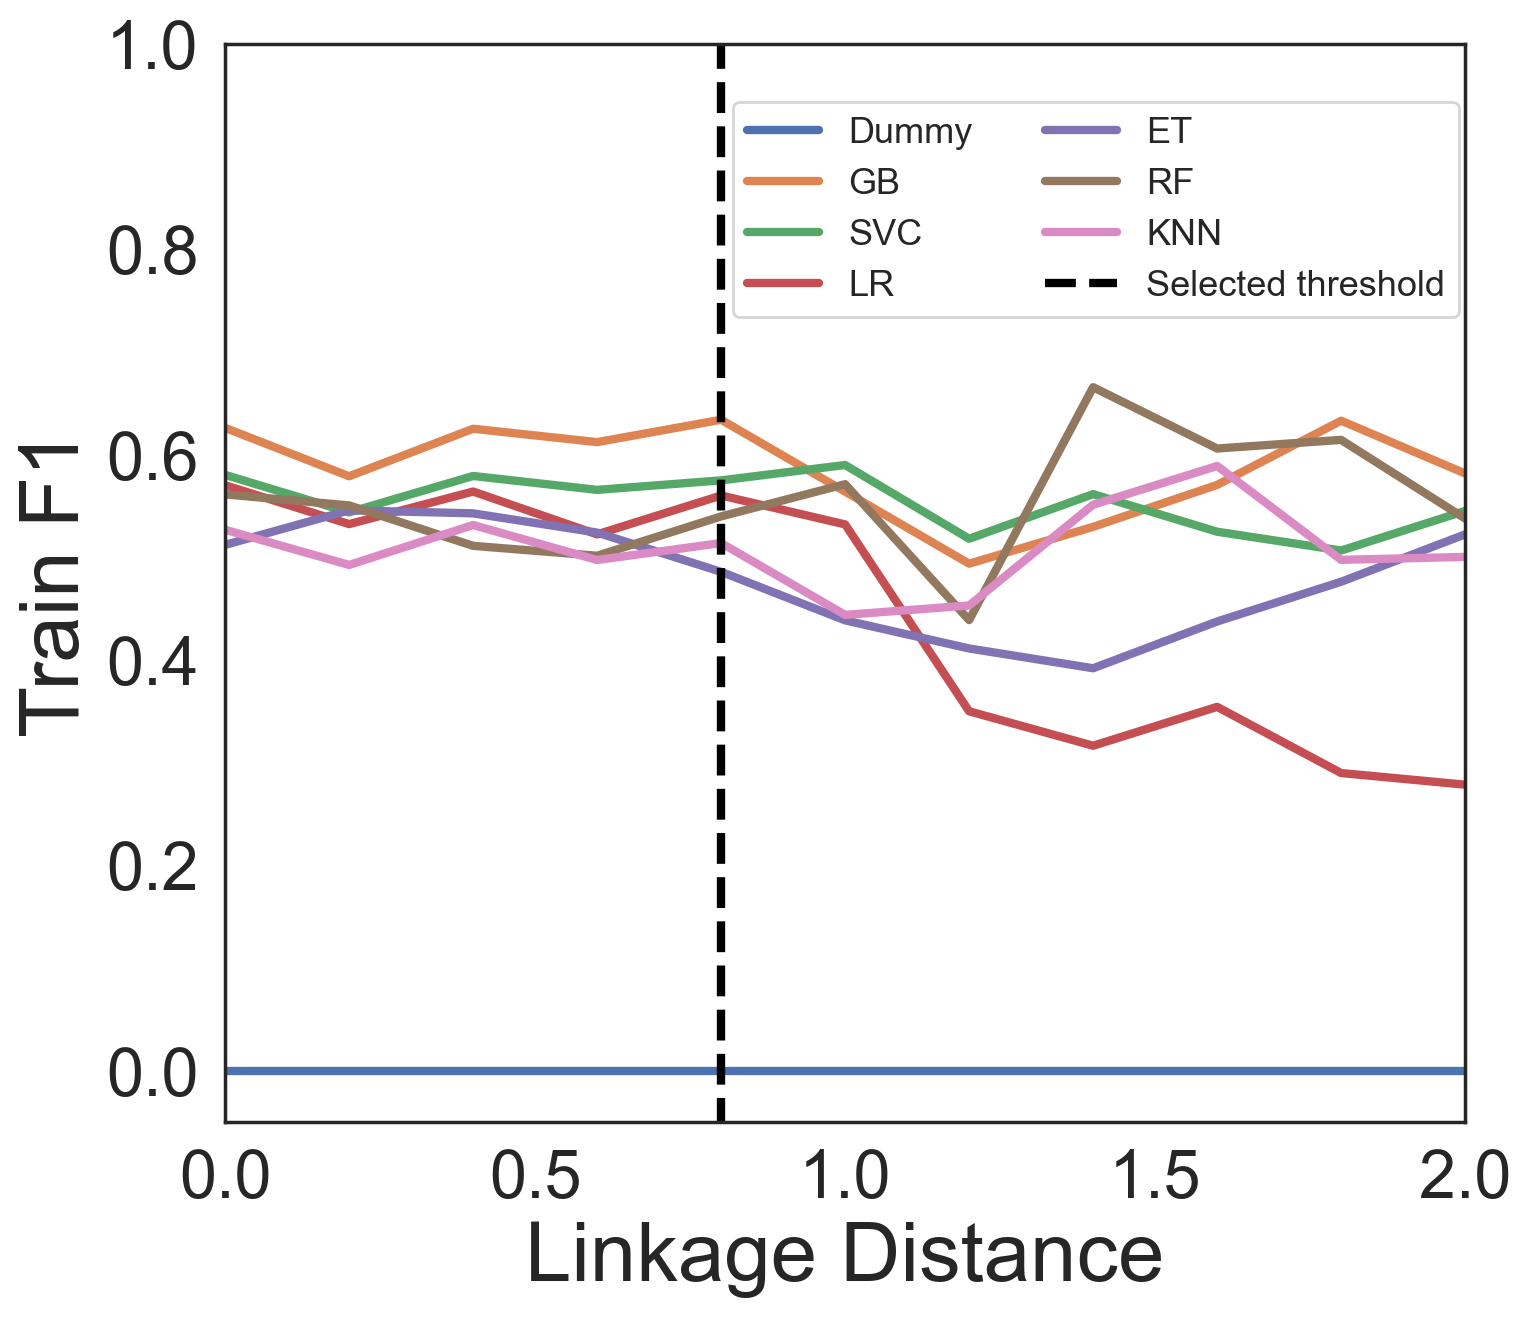

In [30]:
sns.lineplot(data=all_F1_df.T.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable', linewidth=3)
#threshold line
pyplot.plot([0.8,0.8], [-0.1,1], linestyle='--', linewidth=3, color='black',
            label='Selected threshold')
pyplot.xlabel('Linkage Distance', fontsize=30)
pyplot.ylabel('Train F1', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim([-0.05, 1.0])
plt.xlim([0,2])

leg=pyplot.legend(fontsize=13, loc=4,bbox_to_anchor=(1.01, 0.73),ncol=2)
leg.get_lines()[0].set_linewidth(3)
leg.get_lines()[1].set_linewidth(3)
leg.get_lines()[2].set_linewidth(3)
leg.get_lines()[3].set_linewidth(3)
leg.get_lines()[4].set_linewidth(3)
leg.get_lines()[5].set_linewidth(3)
leg.get_lines()[6].set_linewidth(3)
#plt.savefig('SF3C_v2.svg',bbox_inches='tight')
pyplot.show()

In [31]:
#evaluate test set
f1 = {}
AUPR = {}
model=all_model_dict[0.8]['GB']
sel_feat_lst=get_sel_features(Xtrain, meta_prot1.Group,0.8).columns.to_list()
Xtest_sel = Xtest[sel_feat_lst]
print('Xtest_sel shape:',Xtest_sel.shape)

ypred = model.predict(Xtest_sel)
probs = model.predict_proba(Xtest_sel)
pos_probs = probs[:, 1]
F1 = f1_score(ytest, ypred)  
precision, recall, _ = precision_recall_curve(ytest, pos_probs)
AUPR = auc(recall, precision)
print('test F1:',F1)
print('test AUPR:',AUPR)

Xtest_sel shape: (28, 46)
test F1: 0.6956521739130435
test AUPR: 0.8126166438742153


In [32]:
all_model_dict[1.0]

{'Dummy': DummyClassifier(random_state=42),
 'GB': GradientBoostingClassifier(learning_rate=1, max_depth=50, max_features='sqrt',
                            min_samples_leaf=2, random_state=42),
 'SVC': SVC(C=100, gamma=0.01, probability=True, random_state=42),
 'LR': LogisticRegression(C=100, random_state=42, solver='newton-cg'),
 'ET': ExtraTreesClassifier(bootstrap=True, max_depth=50, max_features='sqrt',
                      min_samples_leaf=2, n_estimators=10, random_state=42),
 'RF': RandomForestClassifier(bootstrap=False, max_depth=5, max_features='sqrt',
                        min_samples_leaf=2, min_samples_split=20,
                        n_estimators=10, random_state=42),
 'KNN': KNeighborsClassifier(leaf_size=1)}

In [33]:
all_AUPR_df[i].idxmax()

'RF'

In [34]:
AUPR = {}

for i in np.arange(0,2.2,0.2):
    model=all_model_dict[i]['GB']
    sel_feat_lst=get_sel_features(Xtrain,meta_prot1.Group,i).columns.to_list()
    Xtest_sel = Xtest[sel_feat_lst]
    ypred = model.predict(Xtest_sel)
    probs = model.predict_proba(Xtest_sel)
    pos_probs = probs[:, 1]
    precision, recall, _ = precision_recall_curve(ytest, pos_probs)
    AUPR[i]=auc(recall, precision)

In [35]:
F1 = {}

for i in np.arange(0,2.2,0.2):
    model=all_model_dict[i]['GB']
    sel_feat_lst=get_sel_features(Xtrain,meta_prot1.Group,i).columns.to_list()
    Xtest_sel = Xtest[sel_feat_lst]
    ypred = model.predict(Xtest_sel)
    probs = model.predict_proba(Xtest_sel)
    pos_probs = probs[:, 1]
    F1[i]=f1_score(ytest, ypred)

In [36]:
F1_test_df = pd.DataFrame([F1])

In [37]:
F1_test_df

0.0       0.2  0.4       0.6       0.8  1.0       1.2   1.4  1.6       1.8  \
0  0.6  0.666667  0.6  0.636364  0.695652  0.6  0.583333  0.48  0.5  0.592593   

        2.0  
0  0.666667

In [38]:
AUPR_test_df = pd.DataFrame([AUPR])

In [39]:
AUPR_test_df

0.0       0.2       0.4       0.6       0.8       1.0       1.2  \
0  0.791155  0.793307  0.747901  0.733755  0.812617  0.678279  0.522079   

        1.4       1.6       1.8       2.0  
0  0.483463  0.529945  0.537799  0.540381

In [40]:
F1_test_dfmelt=F1_test_df.T.reset_index().melt(id_vars='index')

In [41]:
F1_test_dfmelt[['variable']] = F1_test_dfmelt[['variable']].replace([0], ['Test F1'])

In [42]:
AUPR_test_dfmelt = AUPR_test_df.T.reset_index().melt(id_vars='index')

In [43]:
AUPR_test_dfmelt[['variable']] = AUPR_test_dfmelt[['variable']].replace([0], ['Test AUPR'])

In [44]:
cmap = plt.get_cmap("tab20")
blue = cmap(np.array([0]))
orange = cmap(np.array([2]))

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


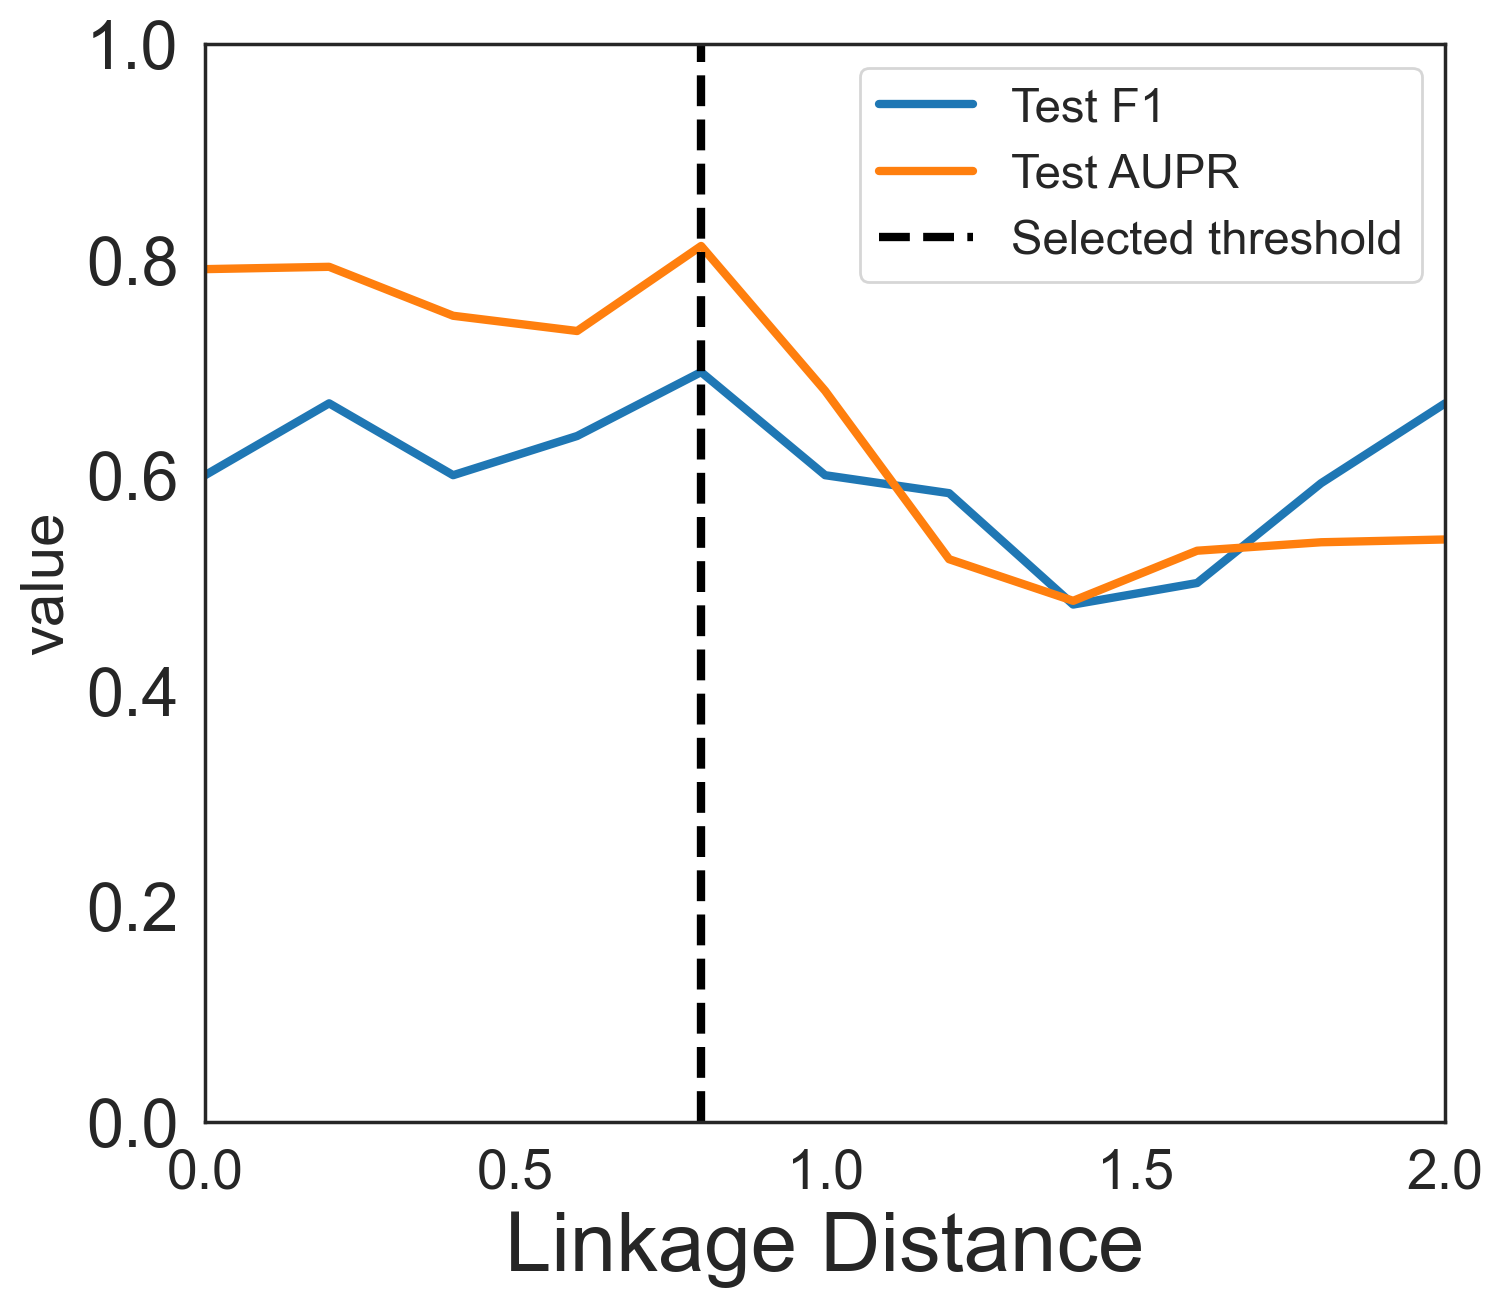

In [45]:
sns.lineplot(data=F1_test_dfmelt, x='index', hue='variable', y='value', linewidth=3, palette=blue)
sns.lineplot(data=AUPR_test_dfmelt, x='index', y='value', hue='variable', linewidth=3, palette=orange)
#threshold line
pyplot.plot([0.8,0.8], [0,1], linestyle='--', linewidth=3, color='black',
            label='Selected threshold')
pyplot.xlabel('Linkage Distance', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
#plt.xticks(np.arange(0,2.1,0.5))
plt.ylim([0, 1.0])
plt.xlim([0, 2.0])


leg=pyplot.legend(fontsize=17, loc=0)
for line in leg.get_lines():
    line.set_linewidth(3.0)
#plt.savefig('SFig3D_v2.svg',bbox_inches='tight')
pyplot.show()

In [46]:
model=all_model_dict[0.8]['GB']

In [47]:
model

GradientBoostingClassifier(learning_rate=1, max_depth=5, max_features='log2',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=10, random_state=42)

In [48]:
Xtest.shape

(28, 195)

In [49]:
sel_feat_lst=get_sel_features(Xtrain,meta_prot1.Group,0.8).columns.to_list()
Xtest_sel = Xtest[sel_feat_lst]

In [50]:
Xtest_sel.shape

(28, 46)

In [51]:
print(f"GB test accuracy: {model.score(Xtest_sel, ytest):.3f}")

GB test accuracy: 0.750


In [52]:
prot = pd.read_csv(r'C:\\Users\\momenzadeha\\Documents\aneurysm_study\LeonFine_ProteinLevel_GFlibrary_DIANN.csv',low_memory=False) 

In [53]:
result = permutation_importance(model, Xtest_sel, ytest, n_repeats=10, random_state=42)
sorted_importances_idx = result.importances_mean.argsort()

In [54]:
genes=[]
for x in Xtest_sel.columns[sorted_importances_idx].to_list():
    genes+=prot[x].iloc[[2]].to_list()

In [55]:
importances_p = pd.DataFrame(
    result.importances[sorted_importances_idx].T, 
    columns=Xtest_sel.columns[sorted_importances_idx].to_list())

In [56]:
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=genes)

In [57]:
pos_PI_p = importances_p.loc[:,importances_p.mean(axis=0) > 0]

In [58]:
pos_PI_prot = importances.loc[:,importances.mean(axis=0) > 0]

In [59]:
len(pos_PI_prot.mean())

19

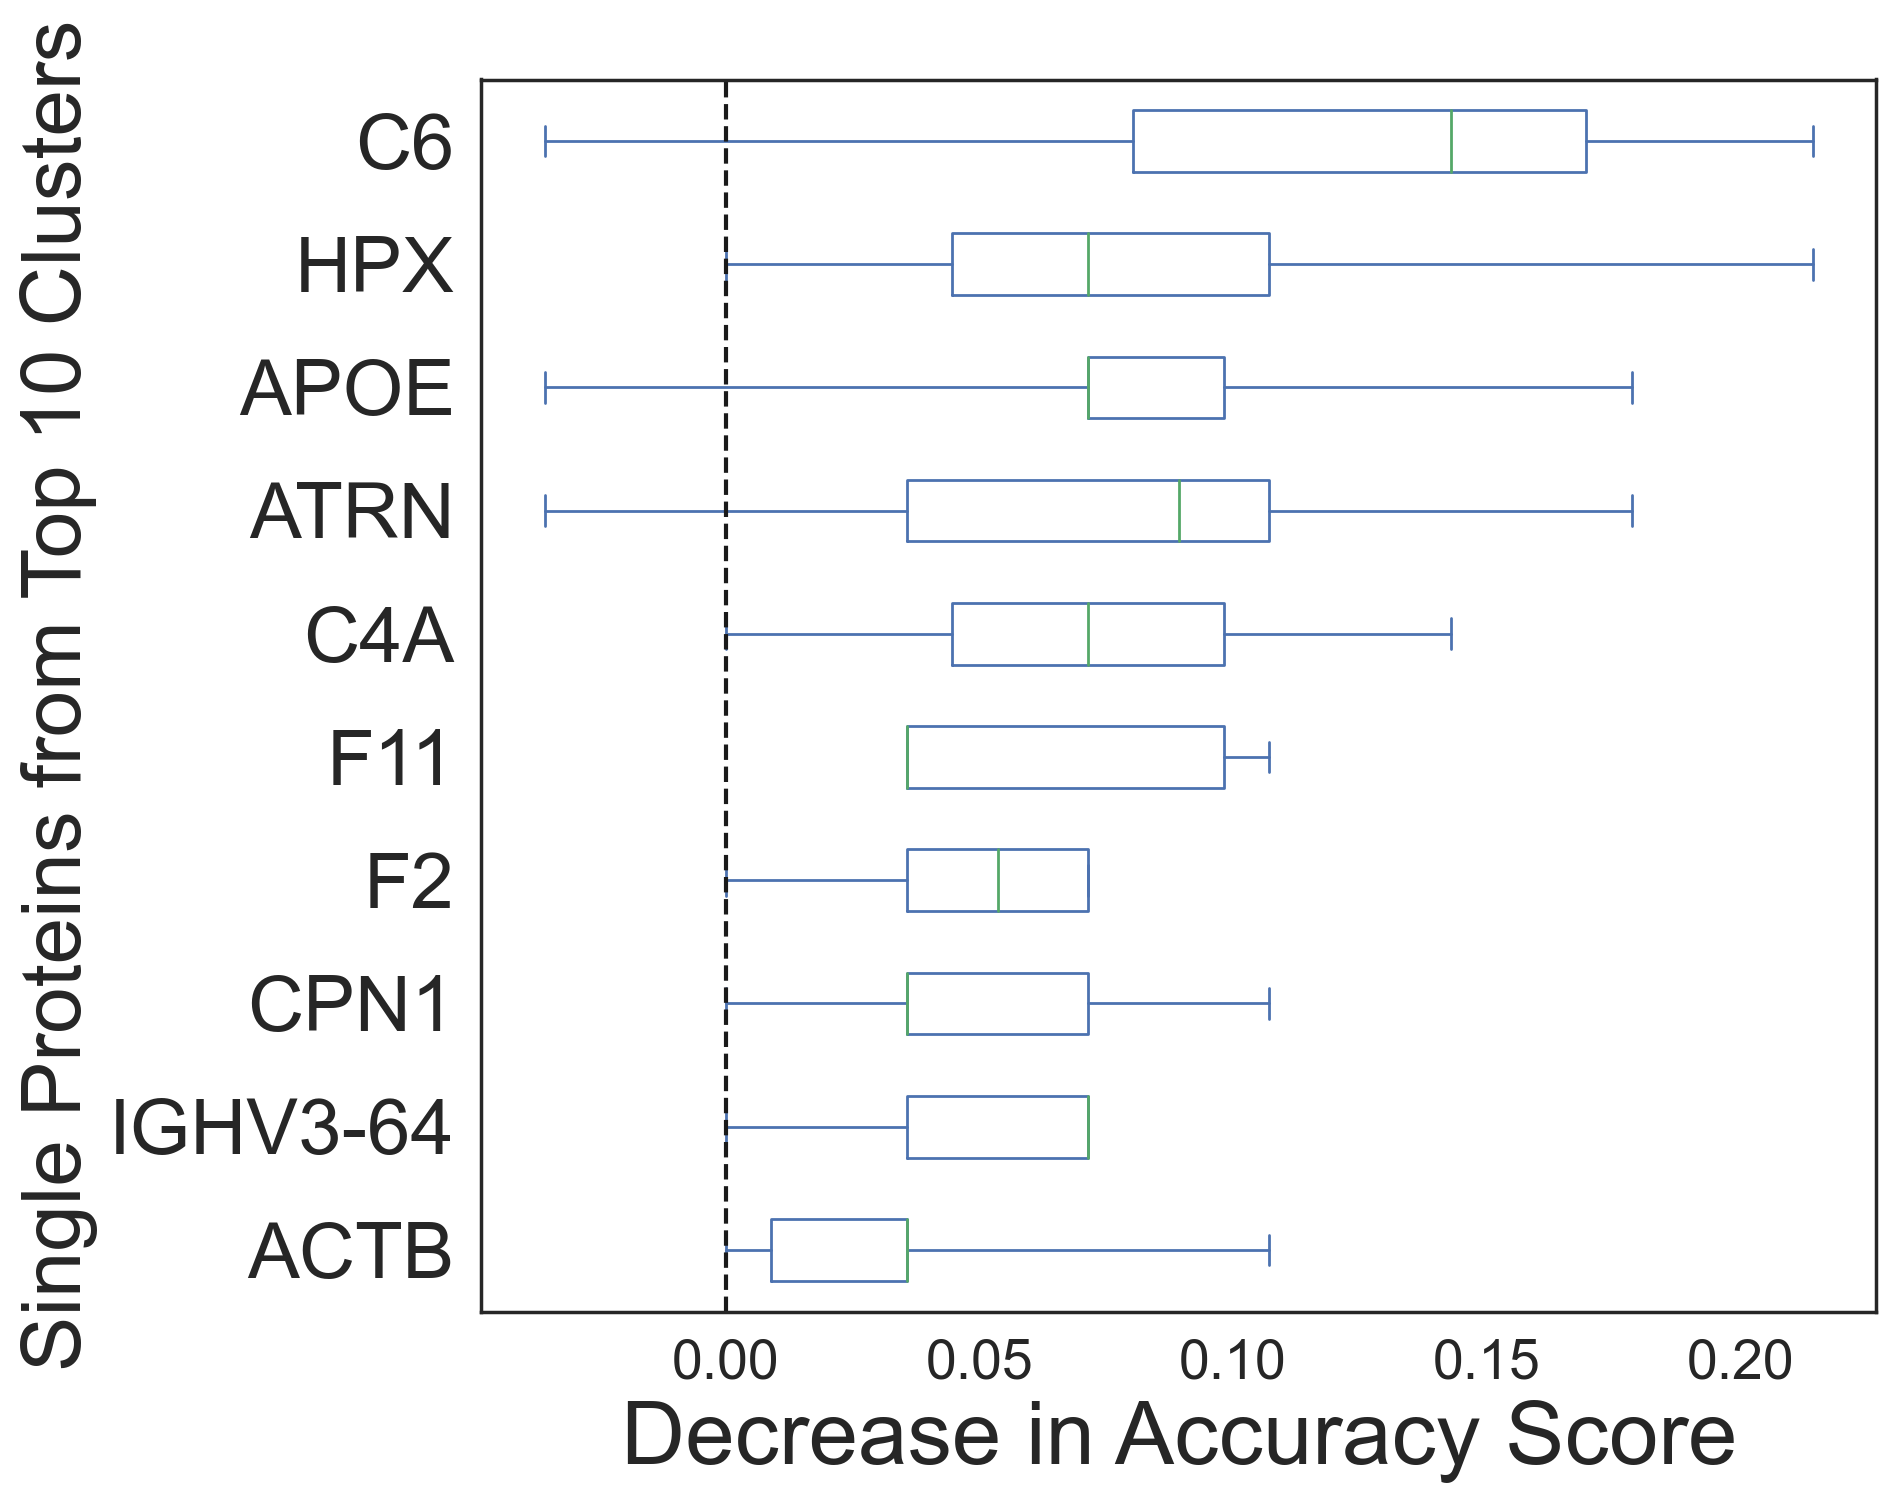

In [60]:
ax = pos_PI_prot.iloc[:,-10:].plot.box(vert=False, whis=10)
#ax.set_title("Permutation Importances (Test Set)", fontsize=30)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score", fontsize=32)
ax.set_ylabel("Single Proteins from Top 10 Clusters", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=28)
#ax.figure.tight_layout()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 8)
#plt.savefig('SFig3E_v2.svg',bbox_inches='tight')

In [61]:
corr = spearmanr(Xtrain).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
dist_linkage, labels=prot1.columns.tolist(), ax=ax1, leaf_rotation=90)

In [62]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.8, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
Xtrain_sel = Xtrain.iloc[:, selected_features]

In [63]:
len(selected_features)

46

In [64]:
#C6='P13671'
print(Xtrain.columns.get_loc("P13671"))
print(cluster_id_to_feature_ids[20])

149
[149, 166]


In [65]:
#HPX='P02790'
print(Xtrain.columns.get_loc("P02790"))
print(cluster_id_to_feature_ids[37])

103
[103, 121, 192]


In [66]:
#APOE='P02649'
print(Xtrain.columns.get_loc("P02649"))
print(cluster_id_to_feature_ids[34])

79
[79, 88, 89, 90]


In [67]:
#ATRN=O75882
print(Xtrain.columns.get_loc("O75882"))
print(cluster_id_to_feature_ids[13])

31
[31, 191]


In [68]:
#'C4A'=P0C0L4
print(Xtrain.columns.get_loc("P0C0L4"))
print(cluster_id_to_feature_ids[31])

137
[137, 138]


In [69]:
#'F11'=P03951
print(Xtrain.columns.get_loc("P03951"))
print(cluster_id_to_feature_ids[29])

104
[104]


In [70]:
#'F2'=P00734
print(Xtrain.columns.get_loc("P00734"))
print(cluster_id_to_feature_ids[42])

36
[36, 39, 167]


In [71]:
#'CPN1'=P15169
print(Xtrain.columns.get_loc("P15169"))
print(cluster_id_to_feature_ids[21])

150
[150, 159, 160]


In [72]:
#'IGHV3-64'=A0A075B6Q5
print(Xtrain.columns.get_loc("A0A075B6Q5"))
print(cluster_id_to_feature_ids[5])

3
[3, 9, 13, 17, 19, 56, 62, 140, 161]


In [73]:
#'ACTB'=P60709
print(Xtrain.columns.get_loc("P60709"))
print(cluster_id_to_feature_ids[46])

175
[175]


In [74]:
PI_features=cluster_id_to_feature_ids[20]+cluster_id_to_feature_ids[37]+cluster_id_to_feature_ids[34]+cluster_id_to_feature_ids[13]+cluster_id_to_feature_ids[31]+cluster_id_to_feature_ids[29]+cluster_id_to_feature_ids[42]+cluster_id_to_feature_ids[21]+cluster_id_to_feature_ids[5]+cluster_id_to_feature_ids[46]

In [75]:
len(PI_features)

30

In [76]:
top30_PI=prot1.columns[PI_features].to_list()

In [80]:
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T, 
    columns=Xtest_sel.columns[sorted_importances_idx].to_list()
)
permutation_order_proteinID = importances[importances.columns[::-1]].columns.tolist()

In [81]:
mean_importances = importances.mean()[::-1]
len(mean_importances)

46

In [82]:
#make the table
proteins_table_list = []
cluster_numbers = []
importances_table_list = []
cluster_rep= []
ordered_cluster_number = []
for key in cluster_id_to_feature_ids.keys():
    proteins_to_add = prot_bcorr.columns[cluster_id_to_feature_ids[key]].tolist()
    proteins_table_list+=proteins_to_add
    importances_table_list+=mean_importances[[proteins_to_add[0]]].tolist()*len(proteins_to_add)
    cluster_numbers+= [key]*len(proteins_to_add)
    #cluster_rep+=proteins_to_add*len(proteins_to_add)
    ordered_cluster_number += np.where(mean_importances.index==proteins_to_add[0])[0].tolist()*len(proteins_to_add)
    cluster_rep+=mean_importances[[proteins_to_add[0]]].index.tolist()*len(proteins_to_add)

In [83]:
ordered_cluster_number=[x+1 for x in ordered_cluster_number]

In [84]:
SuppT3 = pd.DataFrame({'Ordered Cluster Number':ordered_cluster_number, 'Representative Cluster Protein':cluster_rep,
                   'Protein Group (Uniprot)':proteins_table_list, 'Cluster Number':cluster_numbers, 
                   'Mean Decrease in Accuracy (from Permutation Importance)':importances_table_list})

In [85]:
pr_gr=[]
genes=[]
prot_name=[]

for x in SuppT3['Protein Group (Uniprot)']:
    pr_gr+=[x]
    genes+=prot[x].iloc[[2]].to_list()
    prot_name+=prot[x].iloc[[1]].to_list()

In [86]:
SuppT3['Gene Name'] = genes

In [87]:
SuppT3['Protein Name'] = prot_name

In [88]:
SuppT3.to_excel("SuppT3_v2.xlsx", index=False)  

### 4. Find top 30 VIP scores

In [89]:
prot_y = np.array(meta_prot1.Group, dtype=int)

In [90]:
from sklearn.cross_decomposition import PLSRegression

In [91]:
plsr = PLSRegression(n_components=2)
plsr.fit(prot1, meta_prot1.Group)

scores = pd.DataFrame(plsr.x_scores_)
scores.shape

(137, 2)

In [92]:
def vip(model):
  t = model.x_scores_
  w = model.x_weights_
  q = model.y_loadings_
  p, h = w.shape
  vips = np.zeros((p,))
  s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
  total_s = np.sum(s)
  for i in range(p):
      weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
      vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
  return vips

In [93]:
prot1T=prot1.T.reset_index()

In [94]:
prot1T['VIP'] = vip(plsr).tolist()

In [95]:
VIP=prot1T.sort_values(by='VIP', ascending=False)

In [96]:
top30vips=prot1T.sort_values(by='VIP', ascending=False).iloc[:30,:]

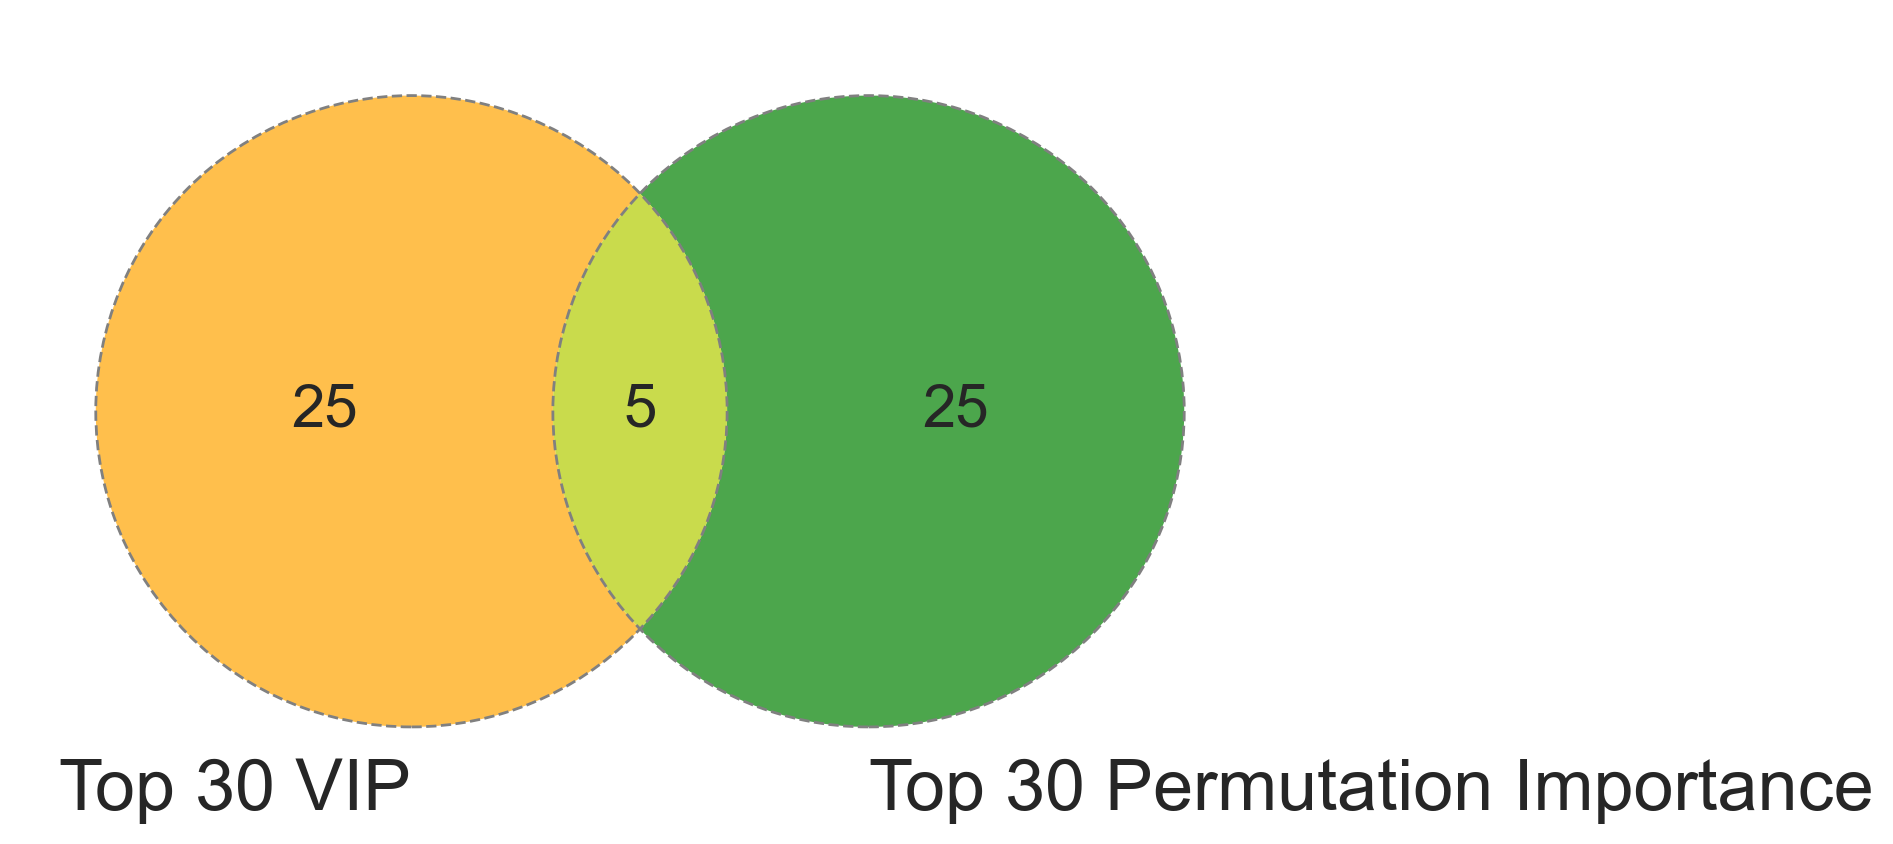

In [97]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

VIP = set(top30vips['index'].tolist())

PI = set(top30_PI)

venn2([VIP, PI], ('Top 30 VIP', 'Top 30 Permutation Importance'),
      set_colors=("orange", "green"), alpha=0.7)
venn2_circles([VIP, PI], linestyle='dashed', linewidth=1, color="grey")
#plt.savefig('SFig4A_v2.svg', bbox_inches='tight')
plt.show()

In [98]:
myset=set(top30vips['index'].tolist() + top30_PI)

In [99]:
len(myset)

55

In [100]:
meta_prot1.Group.shape

(137,)

In [101]:
meta_prot1.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [102]:
prot_gr=meta_prot1[['Group']]

In [103]:
meta_prot=prot_gr.merge(prot1, left_index=True, right_index=True)

In [104]:
#0=Type B
typeb_0=meta_prot.loc[meta_prot['Group'] == 0]

In [105]:
#1=DTAA
dtaa_1=meta_prot.loc[meta_prot['Group'] == 1]

In [106]:
typeb_0=typeb_0.drop(['Group'],axis=1)

In [107]:
dtaa_1=dtaa_1.drop(['Group'],axis=1)

In [108]:
combprot_inT=prot1.T.reset_index()

In [109]:
combprot_inT['mean_typeb'] = typeb_0.mean().tolist()

In [110]:
combprot_inT['mean_dtaa'] = dtaa_1.mean().tolist()

In [111]:
comb_vol=combprot_inT[['index','mean_typeb','mean_dtaa']]

In [112]:
comb_vol['log_fc'] = comb_vol['mean_typeb'] - comb_vol['mean_dtaa']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [113]:
comb_vol.columns

Index(['index', 'mean_typeb', 'mean_dtaa', 'log_fc'], dtype='object')

In [114]:
log_fc=[]
for x in myset:
    log_fc.append(comb_vol[(comb_vol['index']==x)].log_fc.item())

In [115]:
genes=[]
prot_name=[]
log_fc=[]
for x in myset:
    genes+=prot[x].iloc[[2]].to_list()
    prot_name+=prot[x].iloc[[1]].to_list()
    log_fc.append(comb_vol[(comb_vol['index']==x)].log_fc.item())

In [116]:
with open('VIPPIDvA.txt', 'w') as f:
    for line in myset:
        f.write(f"{line}\n")

In [117]:
prot_all=prot1.merge(meta_prot1.Group, left_index=True, right_index=True)

In [118]:
pos_PI_p.iloc[:,-10:].columns

Index(['P60709', 'A0A075B6Q5', 'P15169', 'P00734', 'P03951', 'P0C0L4',
       'O75882', 'P02649', 'P02790', 'P13671'],
      dtype='object')

In [119]:
df_10sel=prot_all[['P13671','P02790', 'P02649', 'O75882','P0C0L4','P03951',
                   'P00734','P15169','A0A075B6Q5','P60709','Group']]

In [120]:
df_10sel.Group.value_counts()

0    75
1    62
Name: Group, dtype: int64

In [121]:
df_10sel[['Group']] = df_10sel[['Group']].replace([0], ['Type B'])
df_10sel[['Group']] = df_10sel[['Group']].replace([1], ['DTAA'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [122]:
df_10sel.Group.value_counts()

Type B    75
DTAA      62
Name: Group, dtype: int64

In [123]:
df_10sel_melt=pd.melt(df_10sel, id_vars=['Group'], value_vars=df_10sel.columns.tolist())

In [124]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,9)},font_scale=1.8)

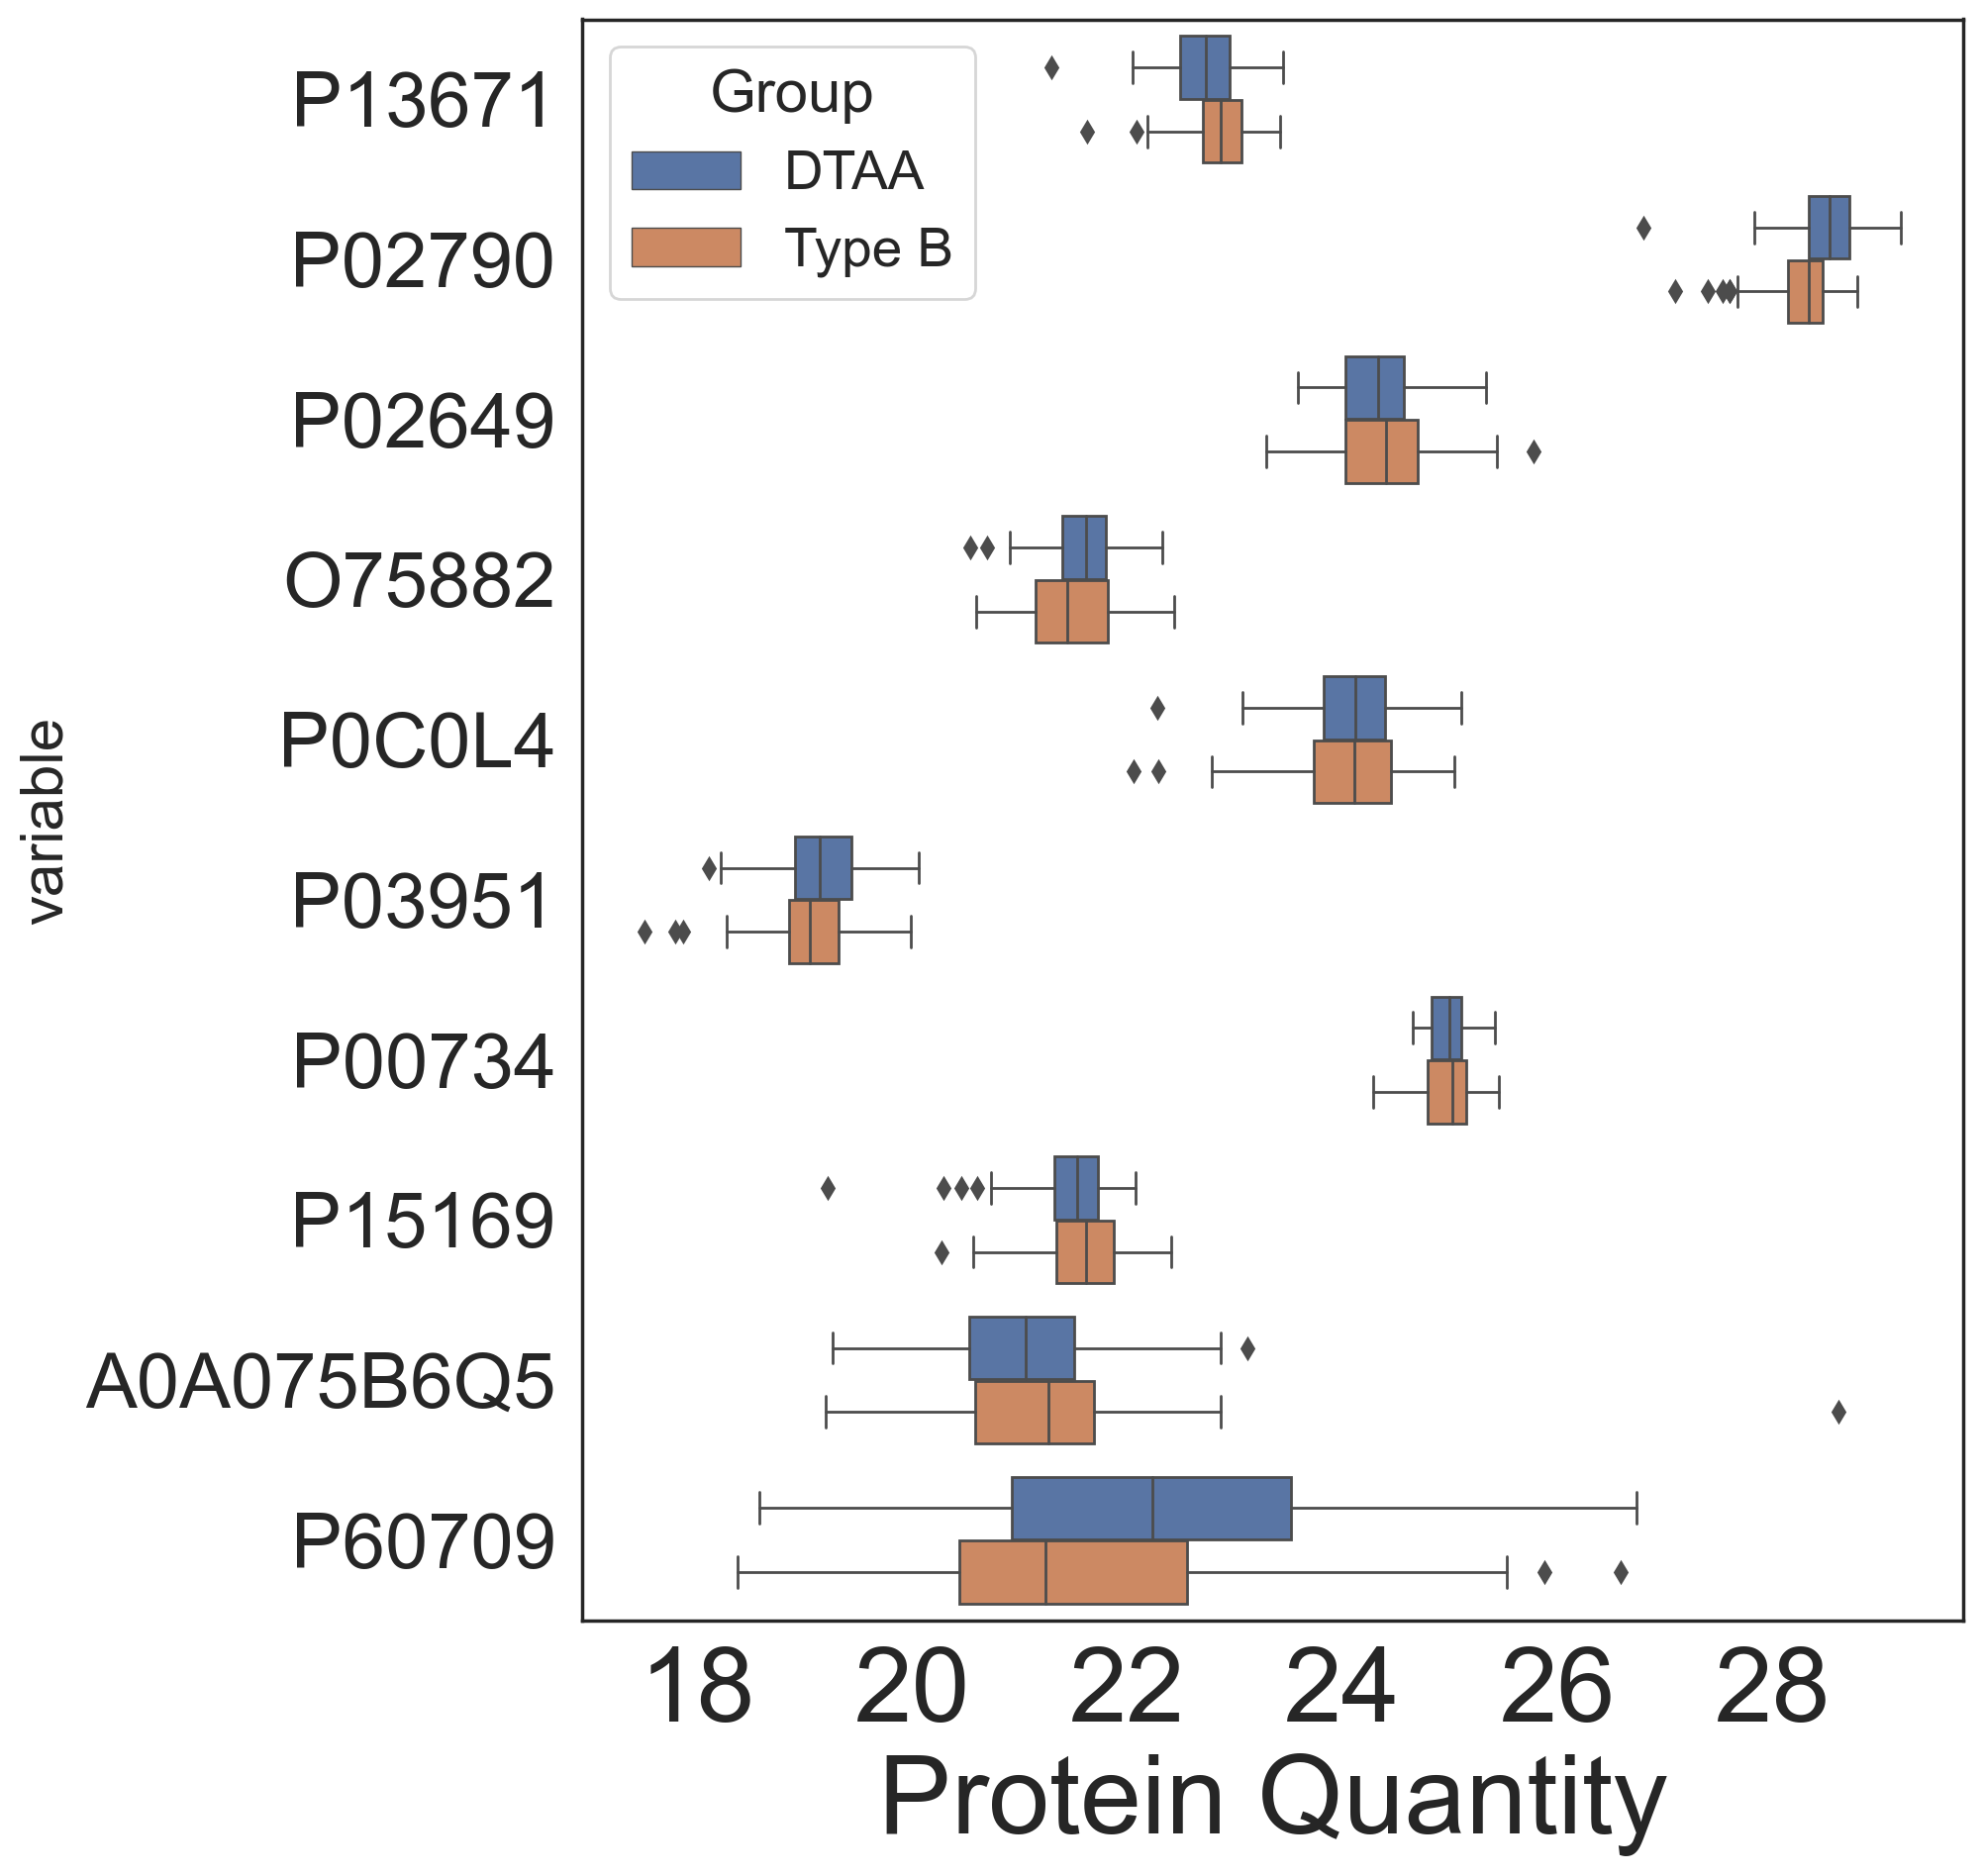

In [125]:
sns.boxplot(data=df_10sel_melt, x='value', y='variable', hue='Group', linewidth=1)

pyplot.xlabel('Protein Quantity', fontsize=40)
plt.xticks(fontsize=38)
plt.yticks(fontsize=28)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 10.5)

#leg=pyplot.legend(fontsize=18, loc='right', bbox_to_anchor=(0.6, 0.45))
#plt.savefig('SFig3F_v2.svg',bbox_inches='tight')
pyplot.show()